In [285]:
from sklearn.base import BaseEstimator, TransformerMixin
#https://github.com/mwv/zca
from zca.zca import zca
import pandas as pd
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import scipy
import numpy as np
import scipy.stats as st
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV

In [ ]:
class ss_yj_Transformer(BaseEstimator, TransformerMixin):
    # add another additional parameter, just for fun, while we are at it
    
    def __init__(self, feature_names=[], additional_param = ""):  
        self.ss_X = StandardScaler()
        self.pt_X = PowerTransformer(standardize=True)
        self.zca_X = zca.ZCA()
        self.ss_y = StandardScaler()
        self.pt_y = PowerTransformer(standardize=True)  
        self.zca_y = zca.ZCA()
        self.feature_names = feature_names
        self.additional_param = additional_param
        self.medians = pd.DataFrame()
        self.mads = []
        self.mad_transformed = pd.DataFrame()

    def fit(self, X, y = None):
        self.ss_X.fit(X)
        self.medians = X.median()
        self.mads = pd.DataFrame(scipy.stats.median_abs_deviation(X,scale='normal'),index=X.columns).T#scipy.stats.median_abs_deviation(X)
        #self.pt_X.fit(self.ss_X.transform(X))
        self.mad_transformed = ((X-X.median())/scipy.stats.median_abs_deviation(X,scale='normal'))
        self.pt_X.fit(self.mad_transformed)        
        self.zca_X.fit(self.pt_X.transform(self.ss_X.transform(X)))
        if (y is not None):
            self.ss_y.fit(y)
            self.pt_y.fit(self.ss_y.transform(y))
            self.zca_y.fit(self.pt_y.transform(self.ss_y.transform(y)))
        return self

    def transform(self, X, y = None):
        #pt_X_ = pd.DataFrame(self.zca_X.fit_transform(self.pt_X.fit_transform(self.ss_X.fit_transform(X))),columns=X.columns,index=X.index)
        #pt_X_ = pd.DataFrame(self.zca_X.fit_transform(self.pt_X.fit_transform(self.mad_transformed)),columns=X.columns,index=X.index)
        pt_X_ = pd.DataFrame(self.zca_X.fit_transform(self.pt_X.fit_transform(self.mad_transformed)),columns=X.columns)
        if (y is None):
            return pt_X_
        else:
            pt_y_ = pd.DataFrame(self.zca_y.fit_transform(self.pt_y.fit_transform(self.ss_y.fit_transform(X))),columns=Y.columns,index=Y.index)
            return pt_X_, pt_y_
        
    def inverse_transform(self, X, y = None):
        #target_X = pd.DataFrame(self.ss_X.inverse_transform(self.pt_X.inverse_transform(self.zca_X.inverse_transform(X))),index=X.index,columns=X.columns)
        target_X = pd.DataFrame((self.pt_X.inverse_transform(self.zca_X.inverse_transform(X))),columns=X.columns)*np.array(self.mads)+np.array(self.medians)
        if (y is None):
            return target_X
        else:
            target_y = pd.DataFrame(self.ss_Xy.inverse_transform(self.pt_y.inverse_transform(self.zca_y.inverse_transform(y))),index=y.index,columns=y.columns)
            return target_X, target_y
        

In [ ]:
exclude = 'States'

In [351]:
bandwidths = np.linspace(1.0, 1.2, 10)

In [352]:
bandwidths

array([1.        , 1.02222222, 1.04444444, 1.06666667, 1.08888889,
       1.11111111, 1.13333333, 1.15555556, 1.17777778, 1.2       ])

In [ ]:
all_data = pd.read_csv('../data/raw/states.csv')

X = all_data[set(all_data.columns).difference([exclude])].copy()
display(X.describe())
X.index=all_data[exclude]
display(X)

,Crime,Poverty,University,Unemployed,Traf Deaths,White,Doctors,Income,Infant Mort,Population
count,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01
mean,1.776357e-17,8.881784e-18,4.440892e-17,-1.332268e-17,-6.106227e-17,4.440892e-18,1.332268e-17,-2.220446e-17,-5.995204e-17,-3.108624e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.981415e+00,-1.920661e+00,-2.656435e+00,-1.627159e+00,-1.914266e+00,-3.965103e+00,-2.352371e+00,-1.788511e+00,-2.091258e+00,-2.142666e+00
25%,-6.550302e-01,-7.501128e-01,-4.998651e-01,-7.560676e-01,-7.295234e-01,-6.088201e-01,-5.097175e-01,-9.075949e-01,-8.888642e-01,-6.638030e-01
50%,-1.611392e-01,7.586969e-03,2.945141e-02,5.597115e-02,2.781613e-02,9.523894e-02,9.250486e-02,2.008025e-02,1.686568e-01,7.985929e-02
75%,6.527081e-01,7.587009e-01,6.056981e-01,6.384850e-01,4.932323e-01,6.184801e-01,5.762914e-01,8.136427e-01,8.147284e-01,6.181143e-01
max,2.249081e+00,2.264157e+00,2.605767e+00,2.281258e+00,3.694339e+00,1.566087e+00,1.712015e+00,1.833320e+00,1.771269e+00,1.970986e+00


Crime         -1.981415
Poverty       -1.920661
University    -2.656435
Unemployed    -1.627159
Traf Deaths   -1.914266
White         -3.965103
Doctors       -2.352371
Income        -1.788511
Infant Mort   -2.091258
Population    -2.142666
dtype: float64

Crime          2.249081
Poverty        2.264157
University     2.605767
Unemployed     2.281258
Traf Deaths    3.694339
White          1.566087
Doctors        1.712015
Income         1.833320
Infant Mort    1.771269
Population     1.970986
dtype: float64

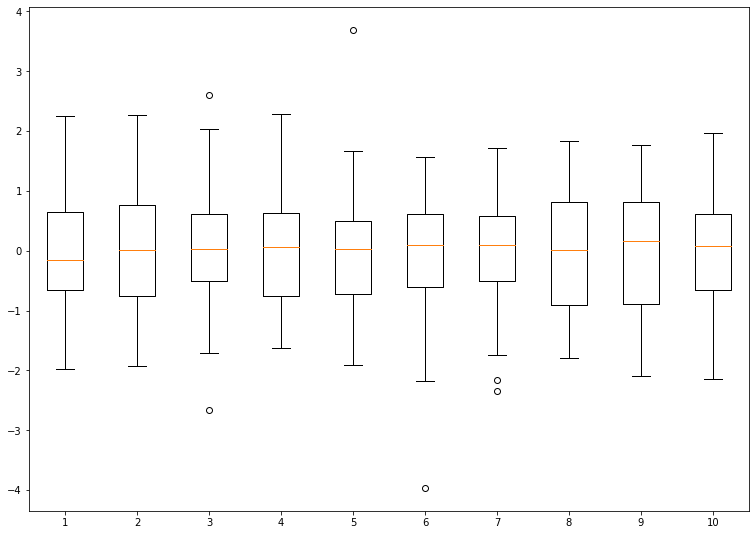

In [540]:
scaler = ss_yj_Transformer()
scaler.fit(X)
X_ = scaler.transform(X)
X_.index=all_data[exclude]
#display(X_)
display(X_.describe())
display(X_.min())
display(X_.max())
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(X_)

array([0.01863815, 0.0373258 , 0.05605482, 0.07504816, 0.09408789,
       0.11345463, 0.13315923, 0.15289688, 0.17282171, 0.19275853,
       0.21280034, 0.23292002, 0.25307448, 0.27337458, 0.29377965,
       0.3142527 , 0.33473277, 0.35523074, 0.3758188 , 0.39641147,
       0.41708503, 0.43776947, 0.45850701, 0.47924512, 0.50001261,
       0.52076998, 0.54151303, 0.56224052, 0.58295359, 0.60362608,
       0.62429545, 0.64495265, 0.66549926, 0.68602842, 0.70650772,
       0.72697682, 0.74738977, 0.76761274, 0.78765454, 0.8075277 ,
       0.82730444, 0.8470142 , 0.86660739, 0.88607947, 0.90538137,
       0.92466651, 0.94361153, 0.96250263, 0.98126597, 1.        ])

array([0.01863815, 0.0373258 , 0.05605482, 0.07504816, 0.09408789,
       0.11345463, 0.13315923, 0.15289688, 0.17282171, 0.19275853,
       0.21280034, 0.23292002, 0.25307448, 0.27337458, 0.29377965,
       0.3142527 , 0.33473277, 0.35523074, 0.3758188 , 0.39641147,
       0.41708503, 0.43776947, 0.45850701, 0.47924512, 0.50001261,
       0.52076998, 0.54151303, 0.56224052, 0.58295359, 0.60362608,
       0.62429545, 0.64495265, 0.66549926, 0.68602842, 0.70650772,
       0.72697682, 0.74738977, 0.76761274, 0.78765454, 0.8075277 ,
       0.82730444, 0.8470142 , 0.86660739, 0.88607947, 0.90538137,
       0.92466651, 0.94361153, 0.96250263, 0.98126597, 1.        ])

Crime
bandwidth: 1.0


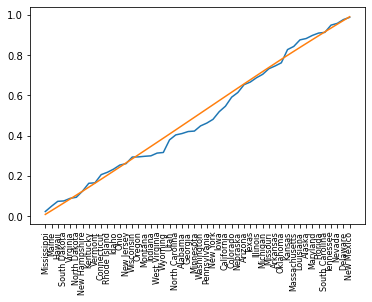

array([-2.34868627])

array([2.35435293])

Crime   -1.981415
dtype: float64

Crime    2.249081
dtype: float64

Poverty
bandwidth: 1.0


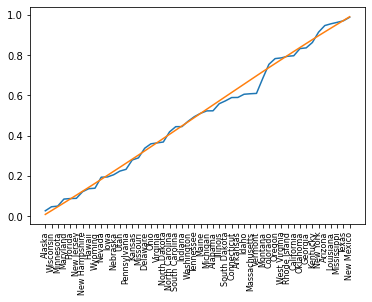

array([-2.3491165])

array([2.35408173])

Poverty   -1.920661
dtype: float64

Poverty    2.264157
dtype: float64

University
bandwidth: 1.0


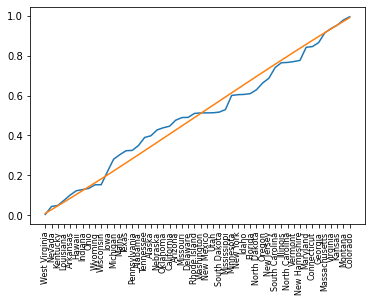

array([-2.35585077])

array([2.3558843])

University   -2.656435
dtype: float64

University    2.605767
dtype: float64

Unemployed
bandwidth: 1.0


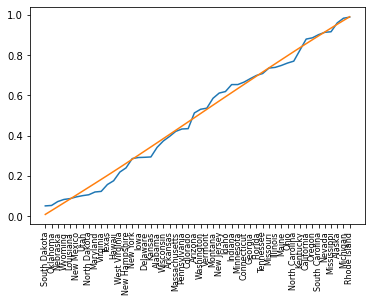

array([-2.34495088])

array([2.35311972])

Unemployed   -1.627159
dtype: float64

Unemployed    2.281258
dtype: float64

Traf Deaths
bandwidth: 1.0


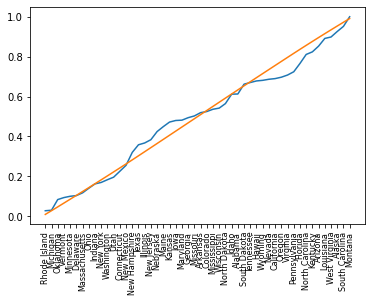

array([-2.35132313])

array([2.35804854])

Traf Deaths   -1.914266
dtype: float64

Traf Deaths    3.694339
dtype: float64

White
bandwidth: 1.0


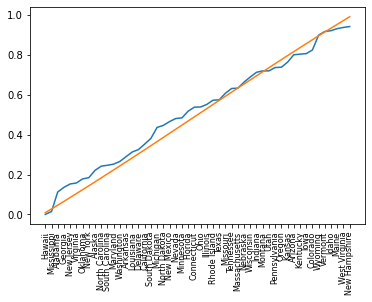

array([-2.36051296])

array([2.3453575])

White   -3.965103
dtype: float64

White    1.566087
dtype: float64

Doctors
bandwidth: 1.0


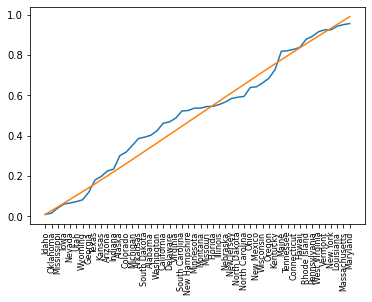

array([-2.35569566])

array([2.34670591])

Doctors   -2.352371
dtype: float64

Doctors    1.712015
dtype: float64

Income
bandwidth: 1.0


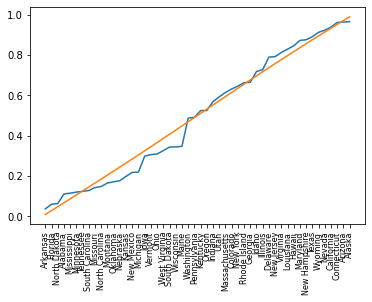

array([-2.34591643])

array([2.34862591])

Income   -1.788511
dtype: float64

Income    1.83332
dtype: float64

Infant Mort
bandwidth: 1.0


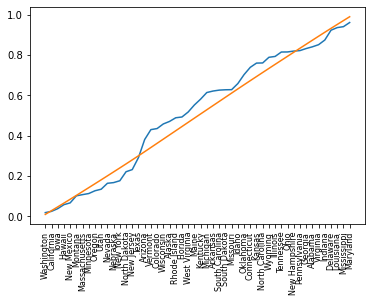

array([-2.35327185])

array([2.34510981])

Infant Mort   -2.091258
dtype: float64

Infant Mort    1.771269
dtype: float64

Population
bandwidth: 1.0


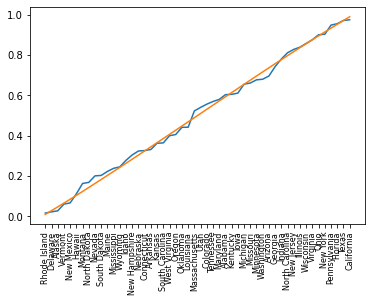

array([-2.35269035])

array([2.35078147])

Population   -2.142666
dtype: float64

Population    1.970986
dtype: float64

In [547]:
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths},
                        )

kde_pct = pd.DataFrame()
raw_pct = pd.DataFrame()

for i in X.columns:
    print(i)
    og = X_[[i]].sort_values(kind="quicksort", by=i,ascending=True)
    og_pct = pd.DataFrame(st.norm.cdf(og),index=og.index)
    plt.plot(og_pct)
    plt.xticks(rotation = 90,size=8)
    grid.fit(og_pct)
    print("bandwidth: " + str(grid.best_params_['bandwidth']))
    kde = KernelDensity(bandwidth=grid.best_params_['bandwidth'], kernel='gaussian')
    kde.fit(og_pct)
    logprobX = np.cumsum(np.exp(kde.score_samples(og_pct)))/np.sum(np.exp(kde.score_samples(og_pct)))
    logprobX = (pd.DataFrame(logprobX).shift(1).replace([np.inf, -np.inf, np.NaN], 0)+pd.DataFrame(logprobX))/2
    logprobX.index = og.index
    kde_pct = pd.concat([kde_pct,logprobX],axis=1)
    raw_pct = pd.concat([raw_pct,og_pct],axis=1)
    plt.plot(logprobX)
    plt.show()
    display(st.norm.ppf(logprobX)[0])
    display(st.norm.ppf(logprobX)[len(logprobX)-1])
    display(X_[[i]].min())
    display(X_[[i]].max())



In [548]:
raw_pct.columns = X.columns
kde_pct.columns = X.columns

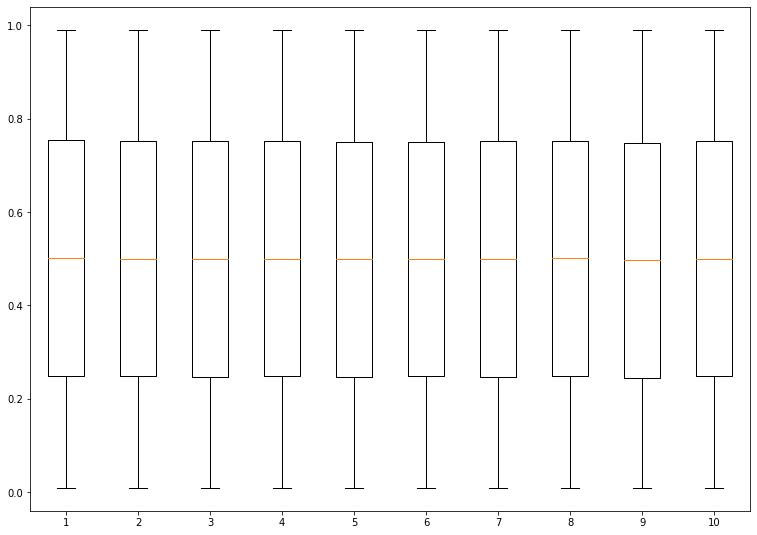

In [549]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(kde_pct)

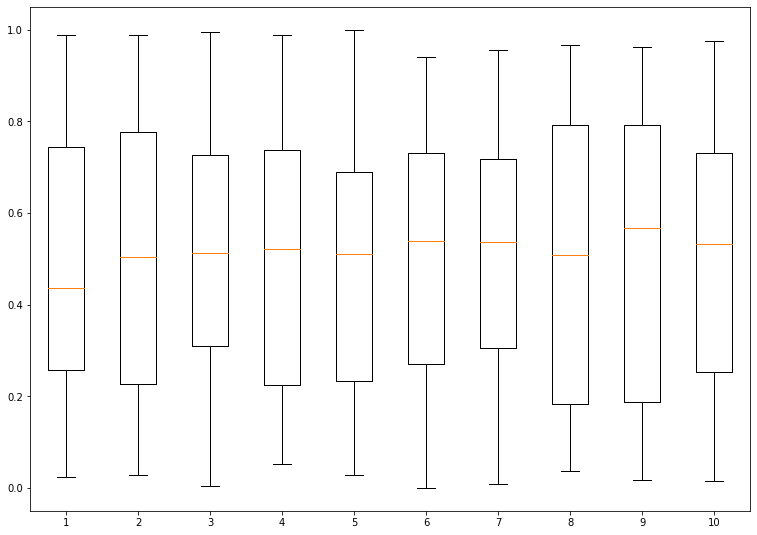

In [550]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(raw_pct)

In [645]:
random_ = pd.DataFrame(np.random.rand(10000,10),columns=X.columns)*(kde_pct.max()-kde_pct.min())+kde_pct.min()
#random_ = pd.DataFrame(np.random.rand(10000,10),columns=X.columns)*(raw_pct.max()-raw_pct.min())+raw_pct.min()
random_set = scaler.inverse_transform(pd.DataFrame(st.norm.ppf(random_),columns=X_.columns)).describe()


In [646]:
random_set.describe()

,Crime,Poverty,University,Unemployed,Traf Deaths,White,Doctors,Income,Infant Mort,Population
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000e+00
mean,1623.888148,1260.519067,1271.070352,1254.237028,1251.214159,1304.544739,1466.264913,42650.954116,1255.478235,9.310345e+06
std,3401.496558,3531.289627,3527.039316,3533.822673,3535.043416,3513.706391,3450.922641,25613.093915,3533.321634,1.740941e+07
min,39.999403,2.625206,4.337996,1.099877,0.361011,-5.954546,51.057869,7382.232435,1.132883,-1.074691e+06
25%,257.216193,9.671302,21.168868,4.039131,1.009817,60.526666,199.403881,27760.101627,5.484338,1.688500e+06
50%,399.891846,12.729799,26.497290,5.312139,1.409852,82.789330,248.421630,48380.040840,6.760299,4.585097e+06
75%,682.453381,17.060460,33.204430,6.814838,2.034491,91.666026,344.862516,52622.356808,8.563755,5.792721e+06
max,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,85888.152495,10000.000000,5.186397e+07


,Crime,Poverty,University,Unemployed,Traf Deaths,White,Doctors,Income,Infant Mort,Population
0,0.116897,0.268784,0.254924,2.126071,-0.338824,-0.554722,-0.032073,1.433795,-0.965122,1.911607


,Crime,Poverty,University,Unemployed,Traf Deaths,White,Doctors,Income,Infant Mort,Population,...,Crime,Poverty,University,Unemployed,Traf Deaths,White,Doctors,Income,Infant Mort,Population
0,0.462768,0.279718,0.978956,0.293073,0.951532,0.183984,0.060717,0.298877,0.739397,0.442198,...,0.462768,0.359907,0.953423,0.293073,0.449298,0.920672,0.595082,0.219554,0.066502,0.661577


In [664]:
dataset = pd.DataFrame()

for p in range(0,1000):
    row = list()
    indices = np.random.choice(raw_pct.shape[0], size=len(raw_pct.columns))
    for i in range(0,len(raw_pct.columns)):
        row.append(raw_pct[[raw_pct.columns[i]]].iloc[indices[i]][0])
        #print()
        
    data = pd.DataFrame(row).T
    data.columns = raw_pct.columns    

    dataset = pd.concat([dataset,data],axis=0)
    
scaler.inverse_transform(pd.DataFrame(st.norm.ppf(dataset),columns=data.columns)).describe()

,Crime,Poverty,University,Unemployed,Traf Deaths,White,Doctors,Income,Infant Mort,Population
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,395.726069,12.795867,26.967817,5.189686,1.399025,81.928596,260.838464,51523.359507,6.794530,5.562754e+06
std,183.192958,2.853383,4.615095,1.217555,0.409304,17.883861,59.030701,8322.589348,1.265790,5.817545e+06
min,26.759570,6.561698,13.302696,2.669794,0.563274,-67.150599,131.017862,30437.114915,3.586190,-1.100717e+06
25%,270.178206,10.782441,23.901310,4.231876,1.128528,80.130291,220.973369,45502.247014,5.809849,2.158139e+06
50%,359.427824,12.563553,26.584208,5.142388,1.346406,85.812347,249.523940,50156.347500,6.784285,3.856812e+06
75%,501.147440,14.521905,29.852958,6.012414,1.585818,90.045398,291.485929,56500.236292,7.610340,6.859276e+06
max,1242.892442,23.726780,43.235129,9.062001,3.525083,98.934361,516.520157,83349.342393,11.992797,5.403646e+07


In [555]:
scaler.inverse_transform(random_).describe()

,Crime,Poverty,University,Unemployed,Traf Deaths,White,Doctors,Income,Infant Mort,Population
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,512.332892,13.334333,27.764006,6.161917,1.410481,82.899121,273.521131,51752.332666,7.164381,7.623805e+06
std,60.301993,0.835323,1.374241,0.358754,0.105722,2.782650,18.917748,2289.636538,0.382310,1.994840e+06
min,353.965580,11.040248,23.735621,5.232395,1.088215,73.689370,230.248988,45352.404296,6.142089,3.888849e+06
25%,464.709592,12.729353,26.766394,5.873420,1.332111,80.913549,258.514865,50103.444110,6.864394,5.973546e+06
50%,509.833815,13.299206,27.741303,6.155242,1.406637,83.182742,272.003619,51661.246791,7.145748,7.323098e+06
75%,557.955376,13.908752,28.719511,6.446675,1.483503,85.116941,286.968619,53290.448437,7.452107,9.056980e+06
max,696.607117,16.242263,32.154261,7.099503,1.815358,89.185134,338.685382,59653.431931,8.430307,1.462403e+07


In [354]:
display(X_.min())
display(X_.max())

Crime         -1.981415
Poverty       -1.920661
University    -2.656435
Unemployed    -1.627159
Traf Deaths   -1.914266
White         -3.965103
Doctors       -2.352371
Income        -1.788511
Infant Mort   -2.091258
Population    -2.142666
dtype: float64

Crime          2.249081
Poverty        2.264157
University     2.605767
Unemployed     2.281258
Traf Deaths    3.694339
White          1.566087
Doctors        1.712015
Income         1.833320
Infant Mort    1.771269
Population     1.970986
dtype: float64

In [ ]:
testzca = zca.ZCA()
testzca.fit(X)
testzca_X = pd.DataFrame(testzca.transform(X),index=all_data[exclude],columns=X.columns)

In [ ]:
#here I impute new values into the "random noise", aka whitened matrix
test1 = testzca_X.loc[['New Mexico']]
test2 = testzca_X.loc[['New Mexico']]
test3 = testzca_X.loc[['New Mexico']]

In [ ]:
test1['Crime']=testzca_X['Crime'].describe()['25%']
test2['Crime']=0
test3['Crime']=testzca_X['Crime'].describe()['75%']

In [ ]:
display(scaler.inverse_transform(test1))
display(scaler.inverse_transform(test2))
display(scaler.inverse_transform(test3))

In [ ]:
#here I impute new values into the "random noise", aka whitened matrix
test4 = X_.loc[['Alaska']]
test5 = X_.loc[['Alaska']]
test6 = X_.loc[['Alaska']]

In [ ]:
test4['Crime']=X_['Crime'].min()
test5['Crime']=0
test6['Crime']=X_['Crime'].max()

In [ ]:
display(scaler.inverse_transform(test4))
display(scaler.inverse_transform(test5))
display(scaler.inverse_transform(test6))

In [ ]:
scaler.inverse_transform(pd.DataFrame(np.zeros(shape=(1,len(X.columns))),columns=X.columns))

In [ ]:
scaler.inverse_transform(X_).describe()

In [ ]:
X_.hist()

In [553]:
scaler.inverse_transform(X_).describe()

,Crime,Poverty,University,Unemployed,Traf Deaths,White,Doctors,Income,Infant Mort,Population
count,50.000000,50.000000,50.000000,50.000000,50.00000,50.00000,50.000000,50.000000,50.000000,5.000000e+01
mean,407.480000,12.732000,26.940000,5.270000,1.40440,81.96200,260.276000,51985.100000,6.830000,6.016154e+06
std,183.633868,2.939002,4.761152,1.253933,0.38654,11.97458,64.363415,8592.657934,1.338786,6.663772e+06
min,118.000000,7.600000,17.100000,3.000000,0.76000,29.70000,168.800000,37790.000000,4.700000,5.232260e+05
25%,278.250000,10.450000,24.025000,4.400000,1.14000,76.15000,218.425000,46161.250000,5.725000,1.779632e+06
50%,345.500000,12.400000,26.200000,5.300000,1.37500,84.55000,249.050000,50173.000000,6.850000,4.313980e+06
75%,520.000000,14.700000,29.825000,6.275000,1.62000,89.85000,274.800000,56903.000000,7.750000,6.490796e+06
max,788.000000,21.200000,38.100000,8.400000,2.45000,96.40000,469.000000,70545.000000,10.600000,3.618591e+07
